## Importanto as bibliotecas necessarias:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

/home/felipe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configurando o dataset e os hiperparametros:

In [2]:
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Definicao das redes neurais adversarias (GAN):

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(z.size(0), 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

## Instanciando os objetos, otimizadores e funcao de perda:

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

## Treinamento:

[Epoch 10/100] [Avg D loss: 0.6007470549742381] [Avg G loss: 1.0282956425348917]
[Epoch 20/100] [Avg D loss: 0.6025367626349132] [Avg G loss: 1.030750644048055]
[Epoch 30/100] [Avg D loss: 0.6120816569328308] [Avg G loss: 0.9959044410387675]
[Epoch 40/100] [Avg D loss: 0.6191811901728312] [Avg G loss: 0.9819597229957581]
[Epoch 50/100] [Avg D loss: 0.622314372698466] [Avg G loss: 0.9741203325589498]
[Epoch 60/100] [Avg D loss: 0.6244772845904032] [Avg G loss: 0.9549571000734965]
[Epoch 70/100] [Avg D loss: 0.6205135122934977] [Avg G loss: 0.9576908871332804]
[Epoch 80/100] [Avg D loss: 0.6292487359841664] [Avg G loss: 0.9481571157773335]
[Epoch 90/100] [Avg D loss: 0.6285124899546305] [Avg G loss: 0.9275318225224812]
[Epoch 100/100] [Avg D loss: 0.6276085419654847] [Avg G loss: 0.9217183127403259]


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

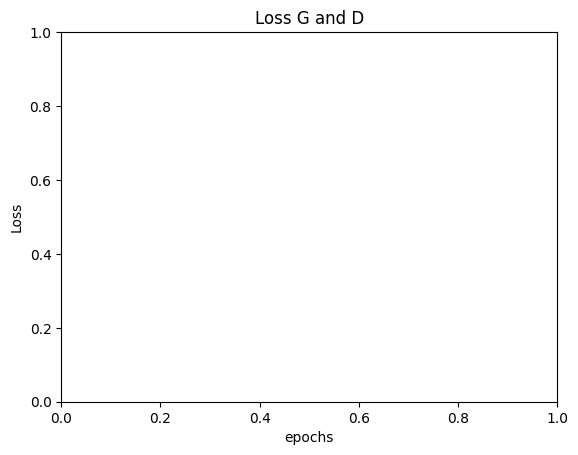

In [6]:
g_loss_per_epoch = []
d_loss_per_epoch = []

for epoch in range(epochs):
    d_loss_accumulated = 0.0
    g_loss_accumulated = 0.0

    for i, (imgs, _) in enumerate(train_loader):
        real = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_D.zero_grad()
        real_imgs = imgs.to(device)
        pred_real = discriminator(real_imgs)
        loss_real = criterion(pred_real, real)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        pred_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(pred_fake, fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        d_loss_accumulated += d_loss.item()

        optimizer_G.zero_grad()
        pred_fake = discriminator(fake_imgs)
        g_loss = criterion(pred_fake, real)
        g_loss.backward()
        optimizer_G.step()

        g_loss_accumulated += g_loss.item()

        if i == len(train_loader) - 1 and (epoch + 1) % 10 == 0:
            d_loss_avg = d_loss_accumulated / len(train_loader)
            g_loss_avg = g_loss_accumulated / len(train_loader)
            print(f"[Epoch {epoch+1}/{epochs}] [Avg D loss: {d_loss_avg}] [Avg G loss: {g_loss_avg}]")

    torch.save(generator.state_dict(), f'./epochs_gan/g/g_epoch_{epoch + 1}.pth')
    torch.save(discriminator.state_dict(), f'./epochs_gan/d/d_epoch_{epoch + 1}.pth')

plt.title('Loss G and D')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(list(range(epochs)), g_loss_per_epoch, label='G', color='b', linestyle='-', marker='o')
plt.plot(list(range(epochs)), d_loss_per_epoch, label='D', color='r', linestyle='--', marker='x')
plt.legend()
plt.show()